Here, I do 1 `forward` pass and manually compare each intermediate output with the cloud version.

In [1]:
import torch
from torch.testing import assert_close

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps'
device_dtype = torch.float16 if device == 'cuda' else torch.float32

## Load the model

In [3]:
from diffusers import StableDiffusionXLPipeline

In [4]:
sdxl_pipe = StableDiffusionXLPipeline.from_single_file('weights/sdxl/sd_xl_base_1.0_0.9vae.safetensors').to(device)

At the end of __init__, the sigmas are tensor([14.6146, 14.5263, 14.4386, 14.3515, 14.2651]) ...
At the end of __init__, the sigmas are tensor([14.6146, 14.5263, 14.4386, 14.3515, 14.2651]) ...


In [5]:
from diffusers.models.controlnetxs import ControlNetXSModel

In [6]:
cnxs = ControlNetXSModel.from_pretrained('weights/cnxs').to(device)

The example script of Heidelberg manually sets scale_list to 0.95

In [7]:
cnxs.scale_list = cnxs.scale_list * 0. + 0.95

In [8]:
cnxs.base_model = sdxl_pipe.unet

Heidelberg uses `timestep_spacing = 'linspace'` in their scheduler, so let's do that as well

In [9]:
from diffusers import EulerDiscreteScheduler

In [10]:
scheduler_cgf = dict(sdxl_pipe.scheduler.config)
scheduler_cgf['timestep_spacing'] = 'linspace'
sdxl_pipe.scheduler = EulerDiscreteScheduler.from_config(scheduler_cgf)

# test it worked
sdxl_pipe.scheduler.set_timesteps(50)
assert sdxl_pipe.scheduler.timesteps[0]==999

# reset
sdxl_pipe.scheduler = EulerDiscreteScheduler.from_config(scheduler_cgf)

At the end of __init__, the sigmas are tensor([14.6146, 14.5263, 14.4386, 14.3515, 14.2651]) ...


In [11]:
assert cnxs.scale_list[0] == .95

In [12]:
from diffusers.pipelines.controlnet_xs.pipeline_controlnet_xs_sd_xl import StableDiffusionXLControlNetXSPipeline

In [13]:
cnxs_pipe = StableDiffusionXLControlNetXSPipeline(
    vae=sdxl_pipe.vae,
    text_encoder=sdxl_pipe.text_encoder,
    text_encoder_2=sdxl_pipe.text_encoder_2,
    tokenizer=sdxl_pipe.tokenizer,
    tokenizer_2=sdxl_pipe.tokenizer_2,
    unet=sdxl_pipe.unet,
    controlnet=cnxs,
    scheduler=sdxl_pipe.scheduler,
)

___

## Run 1 step locally

In [14]:
import numpy as np
import cv2
from diffusers.utils import load_image
import matplotlib.pyplot as plt

In [15]:
class CannyDetector:
    def __call__(self, img, low_threshold, high_threshold):
        return cv2.Canny(img, low_threshold, high_threshold)

def get_canny_edges(image, threshold=(100, 250)):
    image = np.array(image).astype(np.uint8)
    edges = CannyDetector()(image, *threshold)  # original sized greyscale edges
    edges = edges / 255.
    return edges

Let's fix the random seed so we get the same results as the paper. (The paper uses `pytorch_lightning.utilities.seed.seed_everything` which is doesn't exist anymore).

In [16]:
import random
import numpy as np
import torch

def seed_everything(seed):
    # paper used deprecated `seed_everything` from pytorch lightning
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)

RANDOM_SEED_IN_PAPER = 1999158951

Let's also use the same latents as was used with the Heidelberg CVL implementation

In [17]:
latents_sdxl_cloud = torch.load('latents_cloud_no_control.pth', map_location=torch.device(device))
rand_from_cloud = latents_sdxl_cloud[0]

In [18]:
rand_from_cloud.shape

torch.Size([1, 4, 96, 96])

In [19]:
rand_from_cloud.mean(), rand_from_cloud.std()

(tensor(0.0021, device='mps:0'), tensor(14.6598, device='mps:0'))

**Note:** The seed from the cloud is not N(0,1) distirbuted. I seem to have downlaoded the seed *after* the scaling, so let's unscale it manually. The number `14.6146` is the first `sigma` from `EulerDiscreteScheduler` when using `timestep_spacing = 'linear'`.

In [20]:
rand_from_cloud /= 14.6146

**Edit:** Let's not use the 0th latents and scale it manually (I shoud already be N(0,1)...), but instead use x directly

In [21]:
from util_inspect import load_intermediate_outputs

In [22]:
cloud_intermediate_oututs = load_intermediate_outputs('intermediate_output/cloud_debug_log.pkl')
assert cloud_intermediate_oututs[0].msg=='x'
# dim 0 is doubled in x (due to cfg)
assert (cloud_intermediate_oututs[0].t[0]==cloud_intermediate_oututs[0].t[1]).all()
assert rand_from_cloud.shape==cloud_intermediate_oututs[0].t[0][None,:].shape
rand_from_cloud = cloud_intermediate_oututs[0].t[0][None,:]

In [23]:
rand_from_cloud.mean(), rand_from_cloud.std()

(tensor(0.0001), tensor(1.0008))

Some prep to better inspect the denoising process

In [24]:
from util_plot import save_latents, plot_latents_to_pil_grid, real_idx

Okay, let's go

In [25]:
prompt = 'cinematic, shoe in the streets, made from meat, photorealistic shoe, highly detailed'
neg_prompt = 'lowres, bad anatomy, worst quality, low quality'

In [26]:
image = load_image('input_images/shoe_cloud.png')
edges = get_canny_edges(image)

In [27]:
edges_tensor = torch.tensor(edges)
three_edges = torch.stack((edges_tensor,edges_tensor,edges_tensor))
three_edges.shape

torch.Size([3, 768, 768])

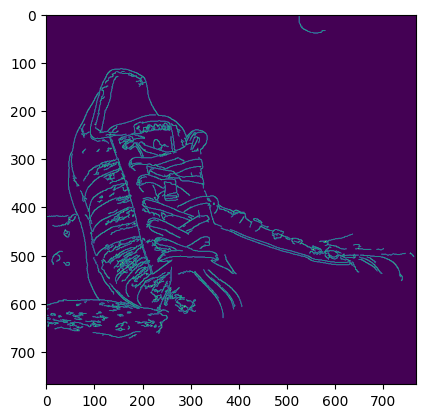

In [28]:
plt.imshow(edges)

In [29]:
cnxs_pipe.controlnet.DEBUG_LOG_by_Umer

False

In [30]:
cnxs_pipe.controlnet.DEBUG_LOG_by_Umer = True
cnxs_pipe.controlnet.DEBUG_LOG_by_Umer_file = 'intermediate_output/local_debug_log.pkl'
cnxs_pipe.controlnet.DEBUG_LOG_by_Umer

True

In [31]:
seed_everything(RANDOM_SEED_IN_PAPER)
cnxs_pipe(prompt, negative_prompt=neg_prompt,image=three_edges, latents=rand_from_cloud)

timestep_spacing = "leading" and timesteps=[981. 961. 941. 921. 901.] ...
sigmas before interpolation: [0.02916753 0.04131448 0.05068044 0.05861427 0.06563709] ...
sigmas after (linear) interpolation: [13.12041569 11.67605019 10.42504501  9.33807945  8.39068699] ...
At end of `set_timesteps`:
sigmas =  tensor([13.1204, 11.6761, 10.4250,  9.3381,  8.3907], device='mps:0') ...
timesteps = tensor([981., 961., 941., 921., 901.], device='mps:0') ...
Passed in latents:  tensor([ 1.3302,  0.5143,  0.4636, -0.5331,  1.0079])
initial_unscaled_latents:  tensor([ 1.3302,  0.5143,  0.4636, -0.5331,  1.0079], device='mps:0')
latents:  tensor([17.5033,  6.7674,  6.1001, -7.0152, 13.2618], device='mps:0')


  0%|          | 0/50 [00:00<?, ?it/s]

/Users/umer/Documents/GitHub/diffusers/diffusers/src/diffusers/models/controlnetxs.py:295: FutureWarning: Accessing config attribute `control_scale` directly via 'ControlNetXSModel' object attribute is deprecated. Please access 'control_scale' over 'ControlNetXSModel's config object instead, e.g. 'unet.config.control_scale'.
  temb = self.control_model.time_embedding(t_emb) * self.control_scale ** 0.3 + self.base_model.time_embedding(t_emb) * (1 - self.control_scale ** 0.3)


ValueError: End of 1st ResNet reached.
Let's analyze the intermediate steps, my man. Don't be intimidated, you can do it. Believe in the you that believes in yourself.

Btw, results are saved to file 'intermediate_output/local_resnet.pkl'.

___

## Load intermediate outputs

These were computed on the cloud with Heidelberg code

In [ ]:
from inspect_intermediate import load_intermediate_outputs, print_metadata

In [ ]:
outp_local = load_intermediate_outputs('intermediate_output/local_debug_log.pkl')

In [ ]:
outp_cloud = load_intermediate_outputs('intermediate_output/cloud_debug_log.pkl')

In [ ]:
len(outp_cloud), len(outp_local)

In [ ]:
print_metadata(outp_cloud)

In [ ]:
print_metadata(outp_local)

In [ ]:
outp_cloud[0].t==outp_local[0].t

In [ ]:
outp_cloud[0].head

In [ ]:
outp_local[0].head

**Q:** Why are x on cloud and local different?

In [ ]:
outp_cloud[0].head / outp_local[0].head

**A:** they differ my a constant multiplicative factor. Therefore, it's likely on cloud a different initial scaling is applied

**Edit** I corrected for that factor. Is the remaining difference just precion error?

___

Let's look at the scheduler

In [ ]:
rand_from_cloud.flatten()[:5]

**Q**: It's unplausible that x (=`outp_local[0].t`) is equal to `rand_from_cloud`. It should be ~13 times as large (because `cnxs_pipe.scheduler.init_noise_sigma=13.1585`

**A:** No, that's fine. The (de)scaling and noise addition/reduction happens outside the denoiser model. Therefore, the denoiser model expects unscaled input.

In [ ]:
cnxs_pipe.scheduler

In [ ]:
sched = cnxs_pipe.scheduler

In [ ]:
len(sched.betas)

In [ ]:
sched.betas[:5], sched.betas[-5:]

In [ ]:
sched.config.beta_start, sched.config.beta_end

In [ ]:
sched.alphas[:5], 1-sched.betas[:5]

In [ ]:
sched.alphas_cumprod[:5], torch.cumprod(sched.alphas[:5], dim=0)

In [ ]:
((1-sched.alphas_cumprod[-1])/sched.alphas_cumprod[-1])**0.5

These are the trainig sigmas

In [ ]:
my_sigmas = np.array(((1 - sched.alphas_cumprod) / sched.alphas_cumprod) ** 0.5)
my_sigmas = np.concatenate([my_sigmas[::-1], [0.0]]).astype(np.float32)
my_sigmas = torch.from_numpy(my_sigmas)

In [ ]:
my_sigmas

In [ ]:
cnxs_pipe.scheduler.sigmas[:5]

**Q:** I've computeed sigma[0] to be ~14.61 but it is ~13.12. Why the difference?

In [ ]:
len(my_sigmas), len(cnxs_pipe.scheduler.sigmas)

**A:** My computed sigmas are the training sigmas, the sigmas used in the pipeline are the inference sigmas, which are computed in `set_timesteps`. Let's compute those manually.

In [ ]:
sched.config.steps_offset

In [ ]:
my_step_ratio = sched.config.num_train_timesteps // sched.num_inference_steps
sched.config.num_train_timesteps, sched.num_inference_steps, my_step_ratio

In [ ]:
my_timesteps = (np.arange(0, sched.num_inference_steps) * my_step_ratio).round()[::-1].copy().astype(np.float32)
print(my_timesteps[:5])

my_timesteps += sched.config.steps_offset
print(my_timesteps[:5])

In [ ]:
np.interp(my_timesteps, np.arange(0, len(my_sigmas)), my_sigmas)[:5]

Note: Because 1) we have more trainig steps than inference steps, and 2) the grid points overlap, the interpolation is (in this case) a simple lookup

In [ ]:
my_sigmas[981], my_sigmas[961]

**Q:** Now I have ~0.1308 which is still not ~13.12.

In [ ]:
from diffusers import EulerDiscreteScheduler

new_sched = EulerDiscreteScheduler.from_config(sched.config)

In [ ]:
new_sched.set_timesteps(50)

In [ ]:
new_sched = EulerDiscreteScheduler.from_config(sched.config)

The sigmas computed in `set_timesteps` are just the reverse of currently saved ones (which represent training), minus the last one

In [ ]:
new_sched.sigmas.flip(0)[1:6]

In [ ]:
new_sched.num_inference_steps=50

my_sigmas = new_sched.sigmas.flip(0)[1:]

my_step_ratio = new_sched.config.num_train_timesteps // new_sched.num_inference_steps
print(new_sched.config.num_train_timesteps, new_sched.num_inference_steps, my_step_ratio)

my_timesteps = (np.arange(0, new_sched.num_inference_steps) * my_step_ratio).round()[::-1].copy().astype(np.float32)
my_timesteps += new_sched.config.steps_offset
print(my_timesteps[:5])

In [ ]:
np.interp(my_timesteps, np.arange(0, len(my_sigmas)), my_sigmas)[:5]

**A:** Reveresing the additonal operations done on the training sigmas in `__init__` (namely reversing and appending [0]) gives the correct inference sigmas

These are the timesteps used in `EulerEDMSampler` (used by Heidelberg):

In [ ]:
np.linspace(1000-1, 0, 50)[:5]

**Q:** They are not equal to the ones used above in `EulerDiscreteScheduler` (`[981, 961, 941, ...]`). Why?

Hypothesis: `EulerEDMSampler` uses `timestep_spacing = 'linspace'` instead of `'leading'`

In [ ]:
np.linspace(0, new_sched.config.num_train_timesteps - 1, new_sched.num_inference_steps, dtype=np.float32)[::-1][:5]

**A:** **Important -** Yup, Heidelberg uses `timestep_spacing = 'linspace'` instead of `'leading'`

___

### Let's continue comparing intermediate outputs

In [ ]:
from inspect_intermediate import load_intermediate_outputs, print_metadata

In [ ]:
outp_local = load_intermediate_outputs('intermediate_output/local_debug_log.pkl')
outp_cloud = load_intermediate_outputs('intermediate_output/cloud_debug_log.pkl')

len(outp_cloud),len(outp_local)

In [ ]:
print_metadata(outp_cloud, n=6)

In [ ]:
print_metadata(outp_local, n=6)

In [ ]:
outp_cloud[3].head, outp_local[3].head

In [ ]:
outp_cloud[4].head, outp_local[4].head

In [ ]:
outp_cloud[5].head, outp_local[5].head

The first few intermediate outputs are equal. Let's compare all.

In [ ]:
def have_same_names(i,do_print=True):
    oc,ol = outp_cloud[i],outp_local[i]
    eq = oc.stage+oc.msg==ol.stage+ol.msg
    if do_print: print('cloud: ', oc.stage,oc.msg,'\nlocal:', ol.stage,ol.msg)
    return eq

def have_same_shapes(i,do_print=True,assert_names_match=True):
    oc,ol = outp_cloud[i],outp_local[i]    
    if assert_names_match: assert oc.stage+oc.msg==ol.stage+ol.msg
    eq = oc.shape==ol.shape
    if do_print:
        eq_str = 'Equal' if eq else 'Different'
        print('>> ',oc.stage, oc.msg, '\t\t',eq_str)
        print('cloud: ', oc.shape,'\nlocal:', ol.shape)
        print()
    return eq

def have_same_values(i,prec=2, do_print=True,assert_names_match=True):
    oc,ol = outp_cloud[i],outp_local[i]    
    if assert_names_match: assert oc.stage+oc.msg==ol.stage+ol.msg
    eq = (oc.head.round(decimals=prec)==ol.head.round(decimals=prec)).all().item()
    if do_print:
        eq_str = 'Equal' if eq else 'Different'
        print('>> ',oc.stage, oc.msg, '\t\t',eq_str)
        print('cloud: ', oc.head,'\nlocal:', ol.head)
        print()
    return eq

In [ ]:
step_comments = [
    'applied base.conv_in',
    'applied ctrl.conv_in',
    'added hint in ctrl',
    'added ctrl -> base',
    'FULL DIVIDE'
] + [
    'concatted base -> ctrl',
    'applied base subblock',
    'applied ctrl subblock',
    'added ctrl -> base',
    'DIVIDE'
] * 8 + [
    'concatted base -> ctrl',
    'applied base block',
    'applied ctrl block',
    'added ctrl -> base'
] + [
    'added ctrl enc -> base dec',
    'concatted base enc -> base dec',
    'applied base block',
    'DIVIDE'
] * 8


def fmt_bool(b, fmt_str):
    b_str = 'y' if b else 'n'
    b_str = ('{:'+fmt_str+'}').format(b_str)
    GREEN, RED, RESET = '\033[92m', '\033[91m', '\033[0m'
    return GREEN+b_str+RESET if b else RED+b_str+RESET

def divider(l, full=True):
    if full: print('-'*l)
    else: print('- '*(l//2))

def compare_intermediate_results(n=None):
    if n is None: n=max(len(outp_cloud),len(outp_local))
    i,c,l,en,es,ev,d = '-','cloud','local','equal name?','equal shape?','equal values?','mean abs Δ'
    print(f'{i:<2} | {c:<19} | {l:<19} | {en:<11} | {es:<12} | {ev:<13} | {d:<10}')
    i,c,l,en,es,ev,d = '','','','','','prec=2',''
    print(f'{i:<2} | {c:<19} | {l:<19} | {en:<11} | {es:<12} | {ev:^13} | {d:<10}')
    total_len = 2+3+19+3+19+3+11+3+12+3+13+3+10
    print_line = partial(divider, l=total_len)
    print_thin_line = partial(divider, l=total_len, full=False)
    last_stage = ''
    step_comments_ = step_comments.copy()
    for i in range(n):
        c,l=outp_cloud[i],outp_local[i]
        eq_name = have_same_names(i,do_print=False)
        eq_shape = have_same_shapes(i,do_print=False)
        eq_vals = have_same_values(i,do_print=False,prec=2)
        
        mean_difference = (outp_cloud[i].t-outp_local[i].t).abs().mean()
        
        if c.stage!=last_stage:
                print_line()
                last_stage=c.stage
            
        print(f'{i:<2} | {c.stage:<6} {c.msg:<12} | {l.stage:<6} {l.msg:<12} | ', end='')
        print(fmt_bool(eq_name, '^11')+' | '+fmt_bool(eq_shape, '^12')+' | '+fmt_bool(eq_vals, '^13')+' | ', end='')
        print(f'{mean_difference:>10.5f}', end='')

        if i>=5:
            print(f'   {step_comments_.pop(0)}')
            if step_comments_[0]=='DIVIDE':
                print_thin_line()
                step_comments_.pop(0)
            if step_comments_[0]=='FULL DIVIDE':
                print_line()
                step_comments_.pop(0)
        else:
            print()

In [ ]:
compare_intermediate_results()

In [ ]:
have_same_shapes(1);

This is okay, as the shapes are broadcastable

In [ ]:
have_same_values(0);

**Q:** Why is the an error in the raw hint? It should be exactly the same, because it is just an canny edge detector applied to the same image.

**Edit: A:** I used slightly different images.. But now I'm using exactly the same images.

In [ ]:
hint_cloud, hint_local = outp_cloud[3].t, outp_local[3].t
(hint_cloud-hint_local).abs().mean(), (hint_cloud-hint_local).abs().max()

In [ ]:
import einops
def compare_two_images(im1,im2,titles=None,figsize=(10,10)):
    def shape(o): return o.shape if hasattr(o,'shape') else o.size
    def make_channel_last(im): return einops.rearrange(im, 'c w h-> w h c') if shape(im)[0] in (1,3) else im
    im1,im2 = make_channel_last(im1),make_channel_last(im2)
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plt.imshow(im1)
    if titles is not None: plt.title(titles[0])
    plt.subplot(1, 2, 2)
    plt.imshow(im2)
    if titles is not None: plt.title(titles[1])
    plt.show()

In [ ]:
compare_two_images(hint_cloud[0], hint_local[0], ('Cloud', 'Local'))

**The detected canny edges are different!**

Here's a plot of their delta

In [ ]:
hint_delta = (hint_cloud[0]-hint_local[0]).abs()
plt.imshow(einops.rearrange(hint_delta, 'c w h-> w h c'))

I was using differnt threshold levels 😲

In [ ]:
edge_local_setting = get_canny_edges(image)
edge_cloud_setting = get_canny_edges(image, threshold=(100,250))  # as in cloud

In [ ]:
plt.figure(figsize=(10,10))

plt.subplot(1, 2, 1)
plt.imshow(edge_cloud_setting)
plt.title('Cloud settings')

plt.subplot(1, 2, 2)
plt.imshow(edge_local_setting)
plt.title('Local settings')

plt.show()

In [ ]:
plt.imshow(hint_cloud[0][0]-edge_cloud_setting)

In [ ]:
(hint_cloud[0][0]-edge_cloud_setting).abs().mean(), (hint_cloud[0][0]-edge_cloud_setting).abs().max()

In [ ]:
edge_wrong_cloud_setting = get_canny_edges(image, threshold=(250,100))

In [ ]:
(hint_cloud[0][0]-edge_wrong_cloud_setting).abs().mean(), (hint_cloud[0][0]-edge_wrong_cloud_setting).abs().max()

In [ ]:
torch.tensor(edge_cloud_setting-edge_wrong_cloud_setting).abs().mean(), torch.tensor(edge_cloud_setting-edge_wrong_cloud_setting).abs().max()

In [ ]:
im_local = load_image('input_images/shoe_old.png')
im_cloud = load_image('input_images/shoe_cloud.png')

In [ ]:
compare_two_images(im_cloud,im_local,('cloud','local'))

In [ ]:
from torchvision.transforms import ToTensor
to_t = ToTensor()

In [ ]:
(to_t(im_local)-to_t(im_cloud)).abs().mean(), (to_t(im_local)-to_t(im_cloud)).abs().max()

In [ ]:
to_t(im_local).max(), to_t(im_local).min()

___

In [ ]:
compare_intermediate_results(n=20)

Okay, now the first larger difference is after the 1st base encoder subblock (which is only a ResNet)

In [ ]:
from diffusers.models.controlnetxs import to_sub_blocks
my_subs = to_sub_blocks(cnxs.base_model.down_blocks[0])
assert len(my_subs)==3
first_base_enc_subblock = my_subs[0]

In [ ]:
first_base_enc_subblock # that's the local module (I can't access cloud modules)

In [ ]:
prev_h_base_cloud = outp_cloud[8].t.to(device)
prev_h_base_local = outp_local[8].t.to(device)

temb_cloud = outp_cloud[1].t.to(device)
temb_local = outp_local[1].t.to(device)

current_h_base_cloud = outp_cloud[10].t.to(device)
current_h_base_local = outp_local[10].t.to(device)

In [ ]:
(current_h_base_local == first_base_enc_subblock(prev_h_base_local, temb_local, None)).all()

In [ ]:
assert_close(current_h_base_local, first_base_enc_subblock(prev_h_base_local, temb_local, None))

**Q:** Do the subblocks on local and cloud do the same thing?

Test: If the subblock on local and cloud were identical, passing the cloud inputs to the local subblock should produce cloud ouputs

In [ ]:
(current_h_base_cloud == first_base_enc_subblock(prev_h_base_cloud, temb_cloud, None)).all()

In [ ]:
assert_close(current_h_base_cloud, first_base_enc_subblock(prev_h_base_cloud, temb_cloud, None))

**A:** Answer, no, they seem to be different

## Next step: Compare ResNet implementation on cloud and local

In [ ]:
import pickle
with open('intermediate_output/local_resnet.pkl', 'rb') as f:
    resnet_local_outp = pickle.load(f)

In [ ]:
for name,o,comm in resnet_local_outp:
    print(comm,name,o.shape if hasattr(o,'shape') else len(o) if hasattr(o,'__len__') else 1)